In [1]:
# Load Libraries
library(Seurat)
library(SingleR)
library(voxhunt)
library(dplyr)
library(data.table)
library(ggplot2)
library(Matrix)

# Set Working Directory
setwd("../")

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
 

# Load Data

In [2]:
counts = Read10X(data.dir = "10XData/GBMorganoids_Trial11")
raw.data <- CreateSeuratObject(counts = counts$`Gene Expression`, project = "GBMOrganoids", min.cells = 3, min.features = 200)
raw.data

10X data contains more than one type and is being returned as a list containing matrices of each type.



An object of class Seurat 
25400 features across 9302 samples within 1 assay 
Active assay: RNA (25400 features, 0 variable features)
 1 layer present: counts

# Demultiplex

In [3]:
# Demultiplex cells based on HTO enrichment
raw.data[['HTO']] <- CreateAssayObject(counts = counts$`Antibody Capture`[,colnames(x=raw.data)]) #Add HTO assay
raw.data <- NormalizeData(raw.data, assay = "HTO", normalization.method = "CLR") #Normalize HTO data using centered log-ratio (CLR) transformation
raw.data <- HTODemux(raw.data, assay = "HTO", positive.quantile = 0.90) #Demultiplex

demux.results1 <- as.matrix(table(raw.data$HTO_classification.global)) #View demultiplexing results
write.csv(demux.results1, file="GBMProject/GBMOrganoid/Metrics/demux1.csv")

Normalizing across features

As of Seurat v5, we recommend using AggregateExpression to perform pseudo-bulk analysis.
This message is displayed once per session.
First group.by variable `ident` starts with a number, appending `g` to ensure valid variable names
This message is displayed once every 8 hours.
Cutoff for WT : 50 reads

Cutoff for PRO : 177 reads

Cutoff for MES : 193 reads



In [4]:
Idents(raw.data) <- "HTO_classification.global"
raw.data <- subset(raw.data, idents = "Singlet") #Extract the singlets

# Visualize enrichment for selected HTOs based on Cell Hashing paper (https://doi.org/10.1186/s13059-018-1603-1)
Idents(raw.data) <- "HTO_maxID"
HTOplot_1 <- RidgePlot(raw.data, assay = "HTO", features = rownames(raw.data[["HTO"]])[1:3], ncol = 3, group.by = "HTO_maxID")
#ggsave("GBMProject/GBMOrganoid/Figures/HTO_QC/HTOplot_1.png", plot = HTOplot_1)

HTOplot_2 <- HTOHeatmap(raw.data, assay = "HTO")
#ggsave("GBMProject/GBMOrganoid/Figures/HTO_QC/HTOplot_2.png", plot = HTOplot_2)

demux.results2 <- as.matrix(table(raw.data$HTO_maxID))
write.csv(demux.results2, file="GBMProject/GBMOrganoid/Metrics/demux2.csv")

demux.results3 <- as.matrix(prop.table(table(raw.data$HTO_maxID)))
write.csv(demux.results3, file="GBMProject/GBMOrganoid/Metrics/demux3.csv")

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


Saving 6.67 x 6.67 in image


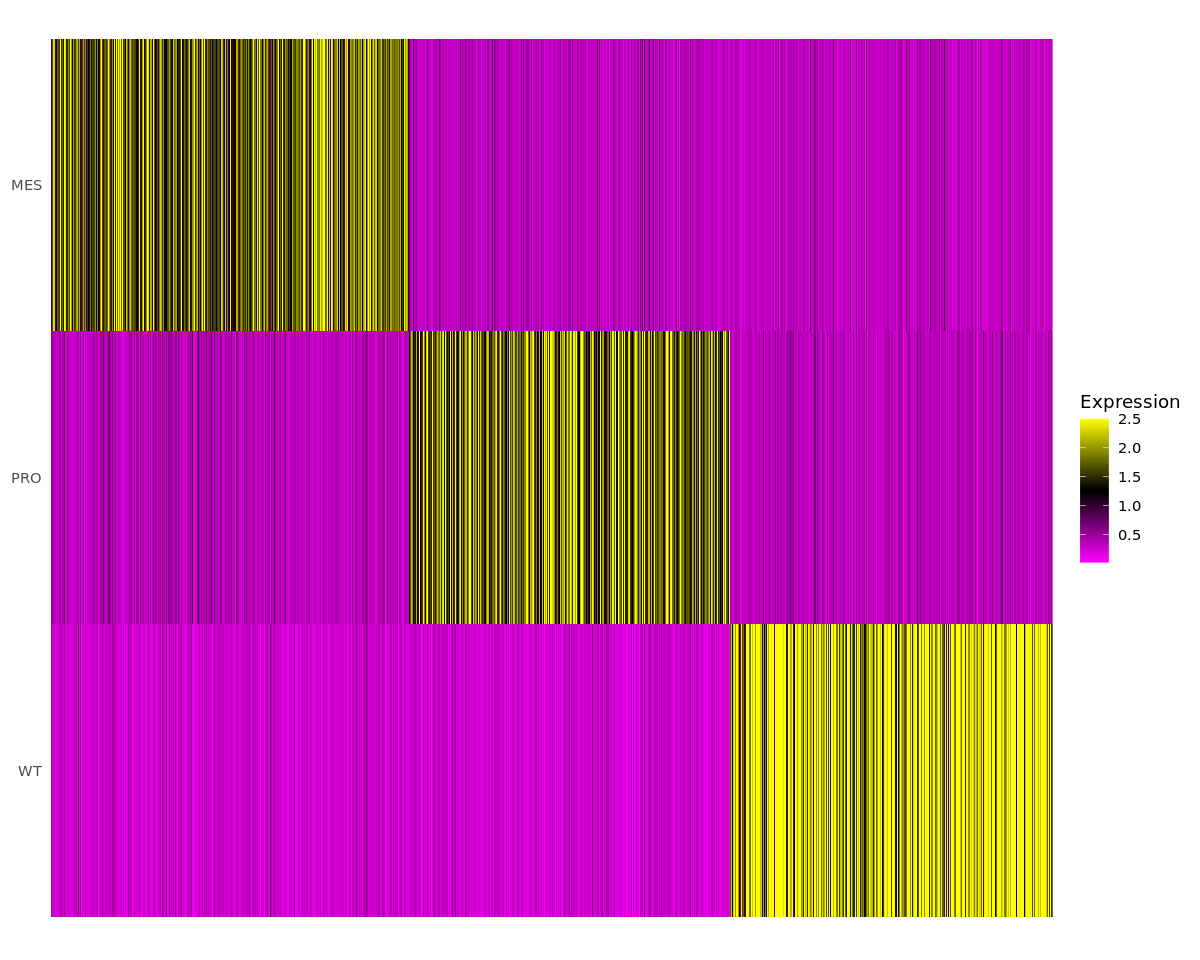

In [5]:
options(repr.plot.width = 10, repr.plot.height = 8)
HTOplot_2
ggsave("GBMProject/GBMOrganoid/Metrics/HTOplot.png", plot = last_plot())

# Quality Control Filtering

In [6]:
# Quality Control Filtering
raw.data[["pct.mito"]] <- PercentageFeatureSet(raw.data, pattern = "^MT-") # calculate percentage mitochondrial genes
saveRDS(raw.data, file = "GBMProject/GBMOrganoid/Checkpoints/0_RawData.rds")
QCplot_1 <- VlnPlot(raw.data, features = c("nFeature_RNA", "nCount_RNA", "pct.mito"), ncol = 3, pt.size = 0)
ggsave("GBMProject/GBMOrganoid/Metrics/QCplot_beforefiltering.png", plot = QCplot_1)

filtered.data <- subset(raw.data, subset = nFeature_RNA > 500 & nFeature_RNA < 6000 & pct.mito < 10)
QCplot_2 <- VlnPlot(filtered.data, features = c("nFeature_RNA", "nCount_RNA", "pct.mito"), ncol = 3, pt.size = 0)
ggsave("GBMProject/GBMOrganoid/Metrics/QCplot_afterfiltering.png", plot = QCplot_2)

qc.results1 <- as.matrix(table(filtered.data$HTO_maxID))
write.csv(qc.results1, file="GBMProject/GBMOrganoid/Metrics/qc1.csv")

qc.results2 <- as.matrix(prop.table(table(filtered.data$HTO_maxID)))
write.csv(qc.results2, file="GBMProject/GBMOrganoid/Metrics/qc2.csv")

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Saving 6.67 x 6.67 in image
Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Saving 6.67 x 6.67 in image


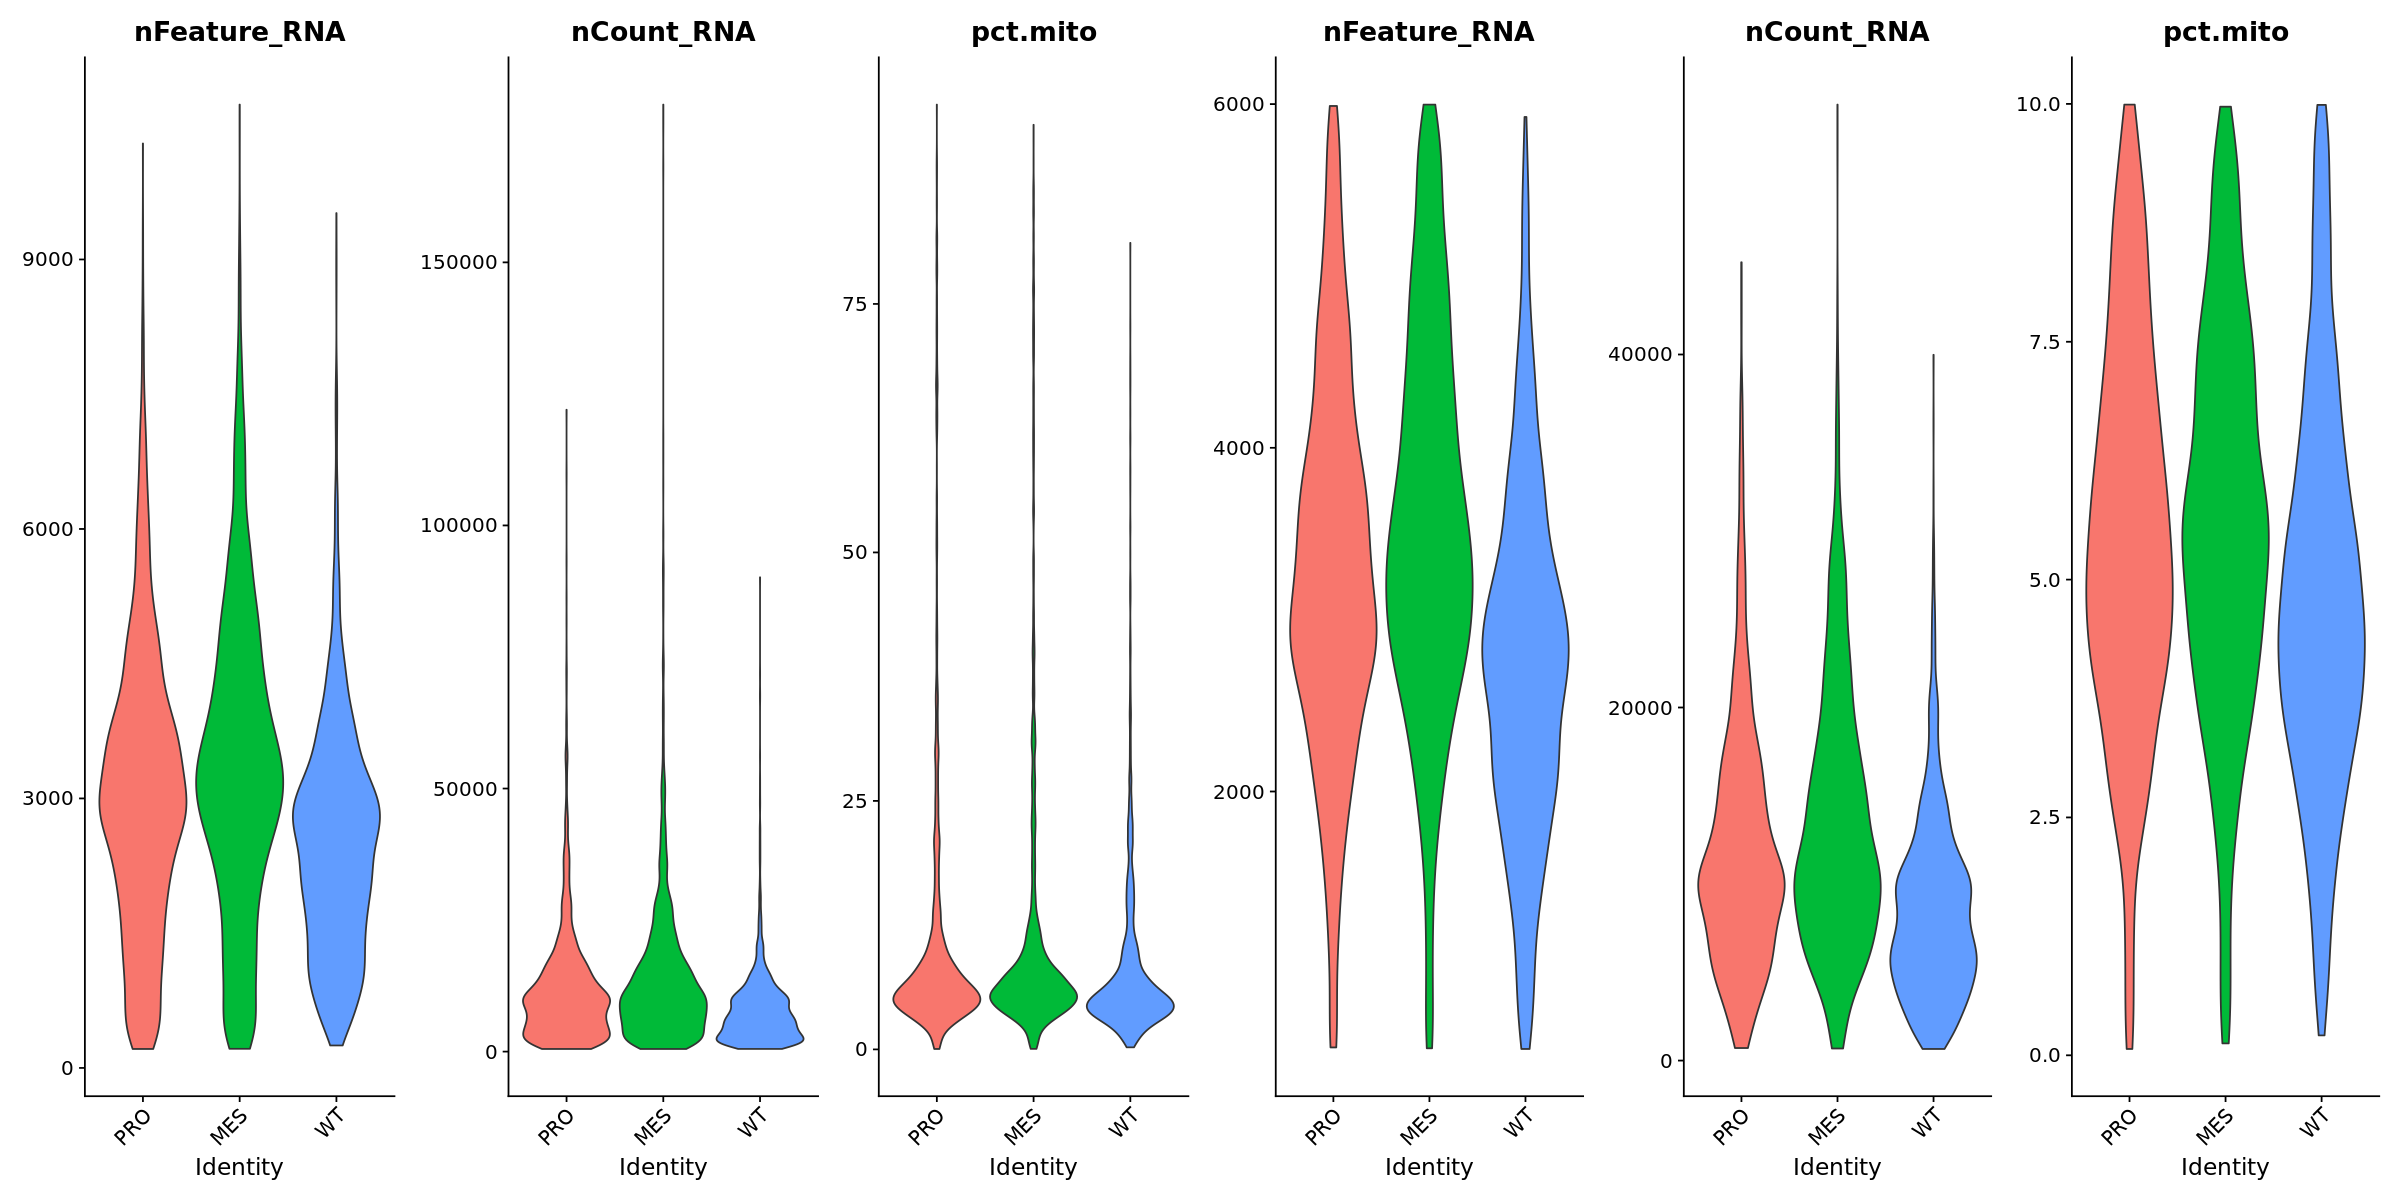

In [7]:
options(repr.plot.width = 20, repr.plot.height = 10)
QCplot_1 | QCplot_2

# Standard Preprocessing Workflow

In [8]:
filtered.data <- NormalizeData(filtered.data, verbose = FALSE)
filtered.data <- FindVariableFeatures(filtered.data, selection.method = "vst", nfeatures = 2000, verbose = FALSE)
filtered.data <- ScaleData(filtered.data, features = rownames(filtered.data), verbose = FALSE)
filtered.data <- RunPCA(filtered.data, verbose = FALSE)
filtered.data <- RunUMAP(filtered.data, dims = 1:30, verbose = FALSE)
filtered.data <- FindNeighbors(filtered.data, reduction = "pca", dims = 1:30, verbose = FALSE)
filtered.data <- FindClusters(filtered.data, resolution = 0.4, verbose = FALSE)
filtered.data <- CellCycleScoring(filtered.data, s.features = cc.genes$s.genes, g2m.features = cc.genes$g2m.genes, search = TRUE, set.ident = FALSE, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Warning message:
“The following features are not present in the object: MLF1IP, attempting to find updated synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, attempting to find updated synonyms”


# Find Cluster Markers

In [9]:
cluster.markers <- FindAllMarkers(filtered.data, only.pos=TRUE, min.pct=0.25)
write.csv(cluster.markers, file = "GBMProject/GBMOrganoid/GeneLists/clustermarkers_1moInVitro_std.csv")

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15



# Cell Type Annotation

## Manual Annotation

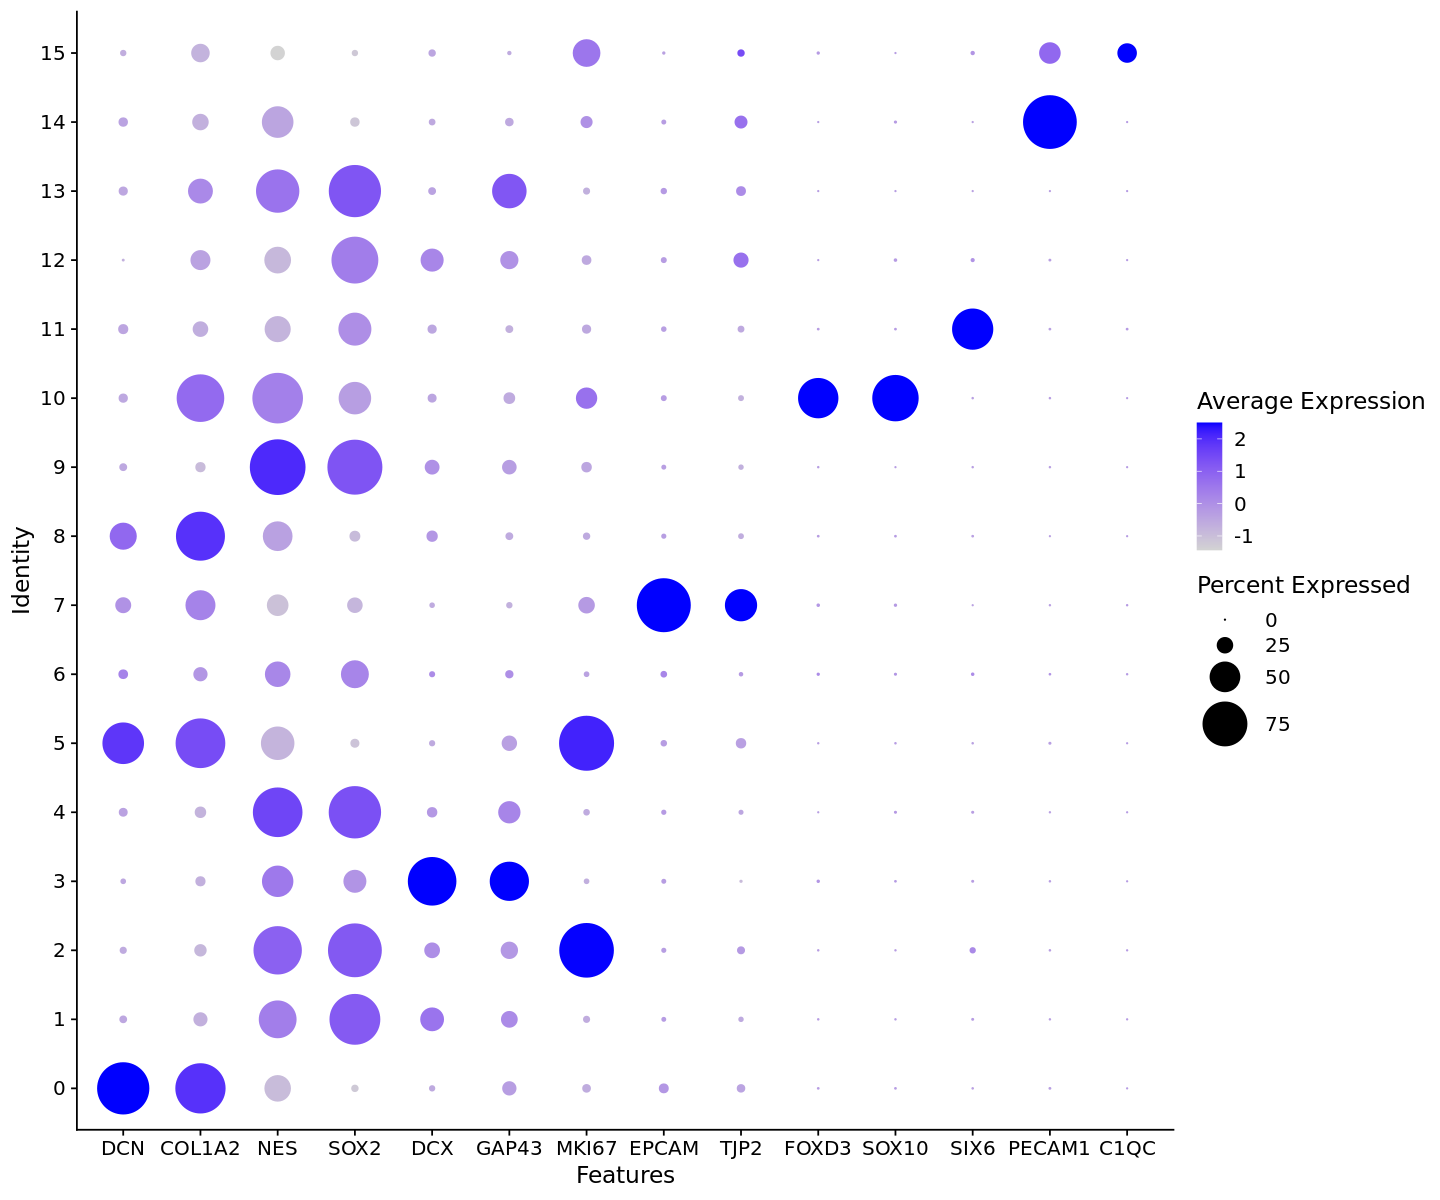

In [10]:
# Visualize Common Cell Identity Markers
Idents(filtered.data) <- "seurat_clusters"

genes = c("DCN","COL1A2", # Mesenchyme markers
          "NES","SOX2", # Radial glia markers
          "DCX","GAP43", # Neuron markers
          "MKI67", # Proliferation marker
          "EPCAM","TJP2", # Neuroepithelial markers
          "FOXD3","SOX10", # Neural Crest markers
          "SIX6", # Retinal Progenitor marker
          "PECAM1", # Endothelial Marker
          "C1QC") # Microglia marker       

options(repr.plot.width = 12, repr.plot.height = 10)
DotPlot(filtered.data, features = genes, dot.scale = 15)

## SingleR w/ Kanton Atlas

In [11]:
# Load and Preprocess Kanton Data
kanton.counts <- Matrix::readMM('GBMProject/GBMOrganoid/Kanton_Atlas/human_cell_counts_consensus.mtx')
genes <- read.table('GBMProject/GBMOrganoid/Kanton_Atlas/genes.txt', sep = '\t', header = FALSE)
rownames(kanton.counts) <- make.unique(genes$V1, sep = ".")

kanton.meta <- read.table('GBMProject/GBMOrganoid/Kanton_Atlas/metadata_human_cells.tsv', sep = '\t', header = TRUE)
rownames(kanton.meta) <- make.unique(kanton.meta$Barcode, sep = ".")

kanton.data <- CreateSeuratObject(counts = kanton.counts, project = "Kanton_BrainOrganoidAtlas", 
                                  min.cells = 3, min.features = 200, meta.data = kanton.meta)

kanton.data <- NormalizeData(kanton.data)

Warning message:
“Data is of class dgTMatrix. Coercing to dgCMatrix.”
Normalizing layer: counts



In [12]:
# Run SingleR Analysis
pred <- SingleR(test = filtered.data[["RNA"]]$data, ref = kanton.data[["RNA"]]$data, labels = kanton.data$cl_FullLineage)
saveRDS(pred, file = "GBMProject/GBMOrganoid/Checkpoints/SingleR_clFullLineage.rds")

pred <- readRDS("GBMProject/GBMOrganoid/Checkpoints/SingleR_clFullLineage.rds")
table(pred$labels)

filtered.data[["SingleR.labels"]] <- pred$labels


choroid plexus/mesenchymal-like cells                    cortical neurons 1 
                                  664                                     8 
                   cortical neurons 2            cycling dorsal progenitors 
                                    5                                   476 
          cycling ventral progenitors ectodermal/neuroectodermal-like cells 
                                   24                                  1106 
       IPs and early cortical neurons              midbrain/hindbrain cells 
                                   61                                   212 
           neuroepithelial-like cells                    retina progenitors 
                                  506                                    84 
                               RGCs 3                          RGCs early 1 
                                   15                                   546 
                         RGCs early 2                          stem cells 1

## VoxHunt Annotation

In [13]:
# Load Allen Brain Atlas data for VoxHunt
load_aba_data("GBMProject/GBMOrganoid/voxhunt/voxhunt_data")

regional_markers <- structure_markers('E13') %>%
    group_by(group) %>%
    top_n(300, auc) %>% 
    {unique(.$gene)}

vox_map <- voxel_map(filtered.data, genes_use=regional_markers)

saveRDS(vox_map, file = "GBMProject/GBMOrganoid/Checkpoints/VoxHunt_voxmap.rds")

## Set cell types

In [15]:
Idents(filtered.data) <- "seurat_clusters"
filtered.data[["celltype"]] <- Idents(filtered.data)
Idents(filtered.data) <- "celltype"

filtered.data <- RenameIdents(object = filtered.data, `0` = "Mesenchyme",`1` = "Radial Glia",`2` = "Proliferating",`3` = "Neuronal",`4` = "Radial Glia",`5` = "Proliferating",
                     `6` = "Radial Glia",`7` = "Neuroepithelial",`8` = "Mesenchyme",`9` = "Radial Glia",`10` = "Neural Crest",`11` = "Retina Progenitor",
                     `12` = "Radial Glia",`13` = "Radial Glia",`14` = "Endothelial",`15` = "Microglia")

filtered.data[["celltype"]] <- Idents(filtered.data)

In [16]:
Idents(filtered.data) <- "seurat_clusters"

filtered.data[["celltype2"]] <- Idents(filtered.data)
Idents(filtered.data) <- "celltype2"

filtered.data <- RenameIdents(object = filtered.data, `0` = "Mesenchyme-1",`1` = "RGC-2",`2` = "Proliferating",
                     `3` = "Neuronal",`4` = "RGC-1",`5` = "Proliferating",`6` = "RGC-3",
                     `7` = "Neuroepithelial",`8` = "Mesenchyme-2",`9` = "RGC-1",
                     `10` = "NeuralCrest",`11` = "Retinal",`12` = "RGC-2",
                     `13` = "RGC-3",`14` = "Endothelial",`15` = "Microglia")

filtered.data[["celltype2"]] <- Idents(filtered.data)

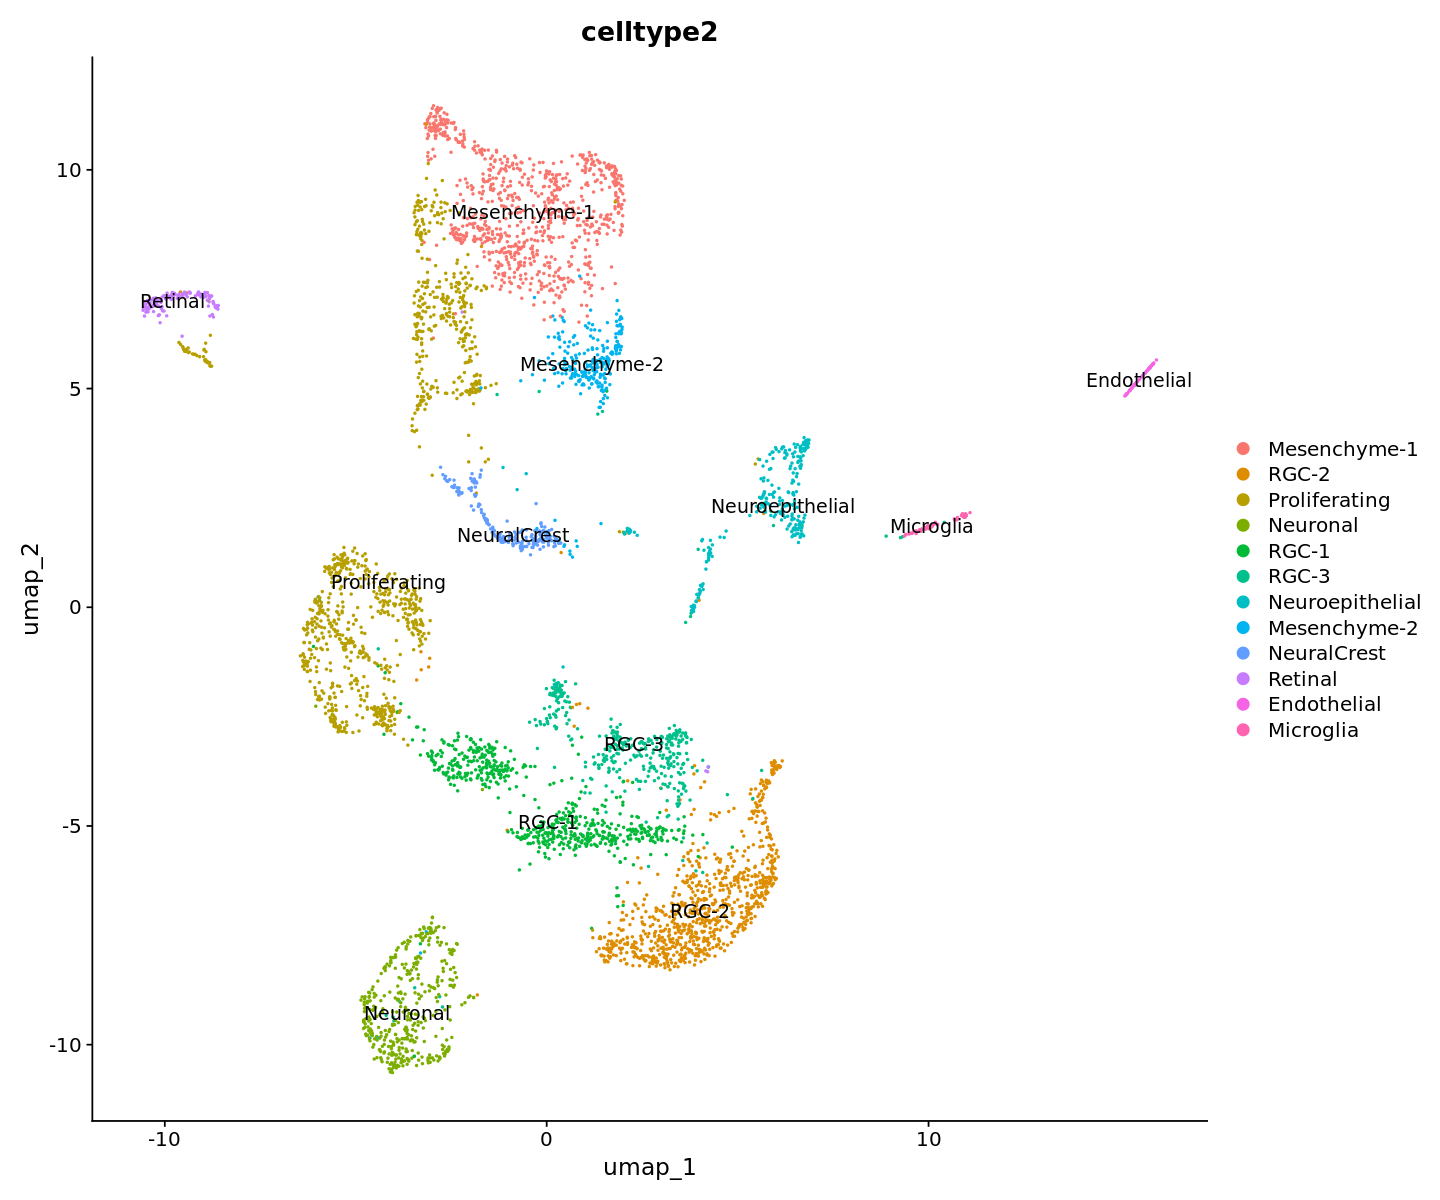

In [17]:
DimPlot(filtered.data, group.by='celltype2', label=T)

# SAVE CHECKPOINT

In [18]:
saveRDS(filtered.data, file = "GBMProject/GBMOrganoid/Checkpoints/1_DataPreprocessing.rds")